In [227]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
import pandas as pd
from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [228]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [229]:
#df_train = pd.read_csv("coxdata.csv")
#df_test = df_train.sample(frac=0.2)
#df_train = df_train.drop(df_test.index)
#df_val = df_train.sample(frac=0.2)
#df_train = df_train.drop(df_val.index)
df_test = pd.read_csv("ctest_data.csv")
df_train = pd.read_csv("ctrain_data.csv")
df_val = pd.read_csv("cvalidation_data.csv")


In [230]:
df_train.head()

,X1,X2,X3,X4,X6,Start,duration,C,event,ttp,X5.1,X5.2,X5.3
0,0,0.256968,0.354844,0.455774,2.000000,0.000,0.276,0,0,17.026,1,0,0
1,0,0.256968,0.286520,0.311620,2.000000,0.276,0.938,0,0,17.026,0,0,1
2,0,0.256968,0.306881,0.535845,2.000000,0.938,3.178,0,0,17.026,0,1,0
3,0,0.256968,0.264290,0.574065,-0.347554,3.178,4.563,0,0,17.026,0,0,1
4,0,0.256968,0.417277,0.026619,0.221840,4.563,5.377,0,0,17.026,1,0,0


In [231]:
cols_standardize = ['X2', 'X4']
cols_leave = ['X1', 'X5.1', 'X5.2','X5.3', 'X6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)

In [232]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [233]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [234]:
val.shapes()

((311, 7), ((311,), (311,)))

In [235]:
val.repeat(2).cat().shapes()

((622, 7), ((622,), (622,)))

In [236]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [237]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

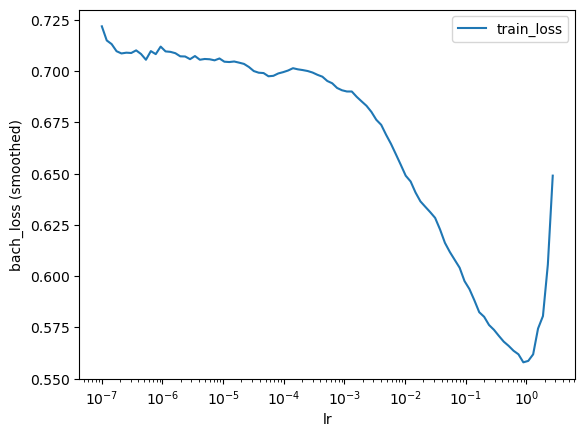

In [238]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [239]:
lrfinder.get_best_lr()

0.08902150854450441

In [240]:
model.optimizer.set_lr(0.01)

In [241]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [242]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.6542,	val_loss: 0.6279
1:	[0s / 0s],		train_loss: 0.5958,	val_loss: 0.6045
2:	[0s / 0s],		train_loss: 0.5487,	val_loss: 0.5924
3:	[0s / 0s],		train_loss: 0.5036,	val_loss: 0.5774
4:	[0s / 0s],		train_loss: 0.4240,	val_loss: 0.5463
5:	[0s / 0s],		train_loss: 0.4403,	val_loss: 0.5726
6:	[0s / 0s],		train_loss: 0.4928,	val_loss: 0.5750
7:	[0s / 0s],		train_loss: 0.4701,	val_loss: 0.5685
8:	[0s / 0s],		train_loss: 0.5198,	val_loss: 0.4872
9:	[0s / 0s],		train_loss: 0.4128,	val_loss: 0.5203
10:	[0s / 0s],		train_loss: 0.4588,	val_loss: 0.5119
11:	[0s / 0s],		train_loss: 0.5036,	val_loss: 0.5086
12:	[0s / 0s],		train_loss: 0.3719,	val_loss: 0.5883
13:	[0s / 0s],		train_loss: 0.4571,	val_loss: 0.5257
14:	[0s / 0s],		train_loss: 0.4177,	val_loss: 0.5150
15:	[0s / 0s],		train_loss: 0.4330,	val_loss: 0.5592
16:	[0s / 0s],		train_loss: 0.5356,	val_loss: 0.5139
17:	[0s / 0s],		train_loss: 0.3265,	val_loss: 0.5095
18:	[0s / 0s],		train_loss: 0.4050,	val_loss: 0.5057
CPU

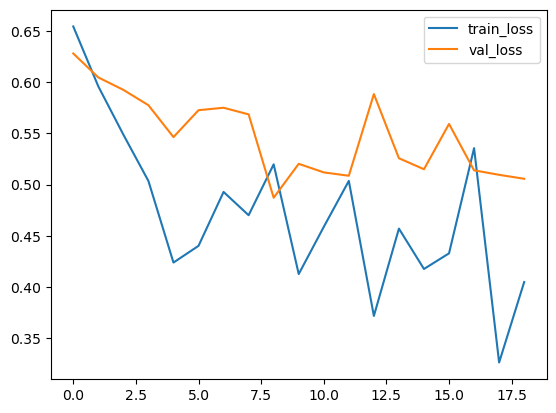

In [243]:
_ = log.plot()

In [244]:
model.partial_log_likelihood(*val).mean()

-3.042082670435938

In [245]:
_ = model.compute_baseline_hazards()

In [246]:
surv = model.predict_surv_df(x_test)

In [247]:
surv.to_csv("survival_coxtime.csv", index=False)

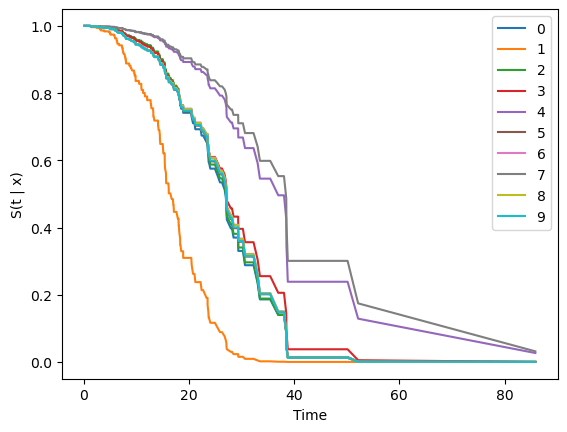

In [253]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

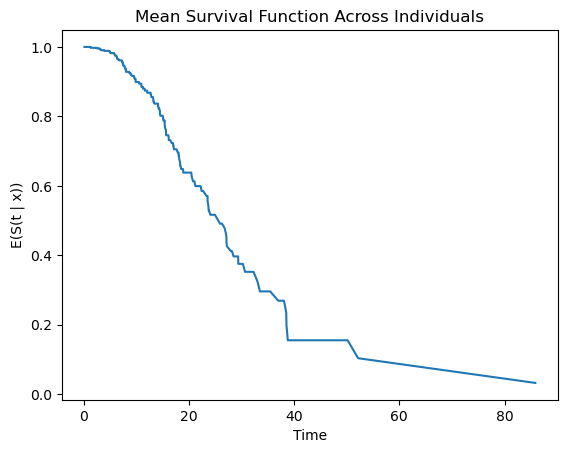

In [256]:
mean_survival = surv.apply(lambda row: row.mean(), axis=1)
mean_survival.plot()
plt.ylabel('E(S(t | x))')
plt.xlabel('Time')
plt.title('Mean Survival Function Across Individuals')
plt.show()
mean_survival.to_csv("msurvival_coxtime.csv", index=False)

In [222]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [265]:
ev.concordance_td()

0.7045454545454546

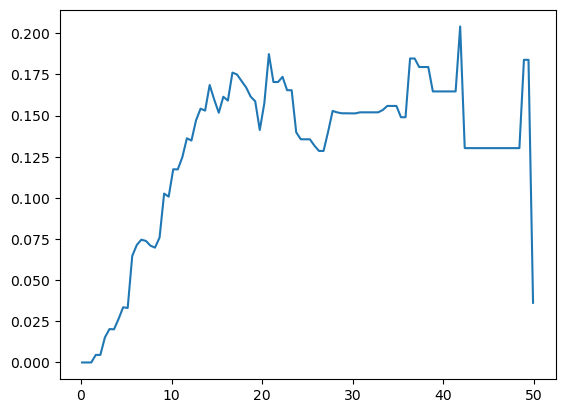

In [224]:
time_grid = np.linspace(durations_test.min(), durations_test.max(),100)
_=ev.brier_score(time_grid).plot()

In [225]:
ev.integrated_brier_score(time_grid)

0.13077209100758655

tim = np.arange(15,22)
ev.brier_score(tim)

In [263]:
tim = np.arange(15,45,7) 
ev.brier_score(tim)

15    0.155433
22    0.170413
29    0.151418
36    0.149019
43    0.130246
Name: brier_score, dtype: float64